In [27]:
%matplotlib notebook

import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
#from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

RASTER_DATA_FILE = "data/image/2298119ene2016recorteTT.tif"
TRAIN_DATA_PATH = "data/train/"
TEST_DATA_PATH = "data/test/"

In [21]:
from pylab import *
img=load("dt.npy")
rows, cols, n_bands = img.shape
files = [f for f in os.listdir(TRAIN_DATA_PATH) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(TRAIN_DATA_PATH, f) for f in files if f.endswith('.shp')]
print(shapefiles)

['data/train/D.shp', 'data/train/B.shp', 'data/train/A.shp', 'data/train/E.shp', 'data/train/C.shp']


In [22]:
ground_truth = load("gt.npy")
classes = np.unique(ground_truth)[1:]  # 0 doesn't count
print(classes)

[ 1.  2.  3.  4.  5.]


In [23]:
segments=load("segments.npy")
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

Training segments for class 1: 55
Training segments for class 2: 35
Training segments for class 3: 52
Training segments for class 4: 99
Training segments for class 5: 40


In [24]:
accum = set()
intersection = set()
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

In [25]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

<IPython.core.display.Javascript object>


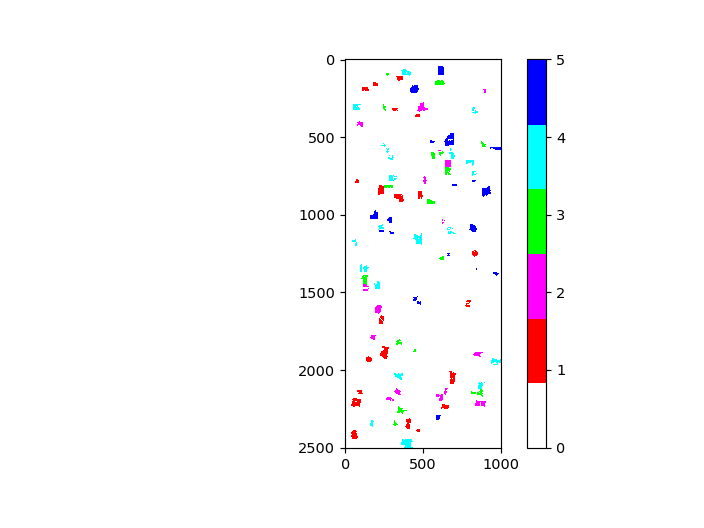

In [28]:
plt.figure()
cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])

In [29]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features

In [30]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings

segment_ids = np.unique(segments)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

Created 26835 objects


In [31]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

Training samples for class 1: 55
Training samples for class 2: 35
Training samples for class 3: 52
Training samples for class 4: 99
Training samples for class 5: 40


In [32]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_objects, training_labels)
predicted = classifier.predict(objects)

<IPython.core.display.Javascript object>


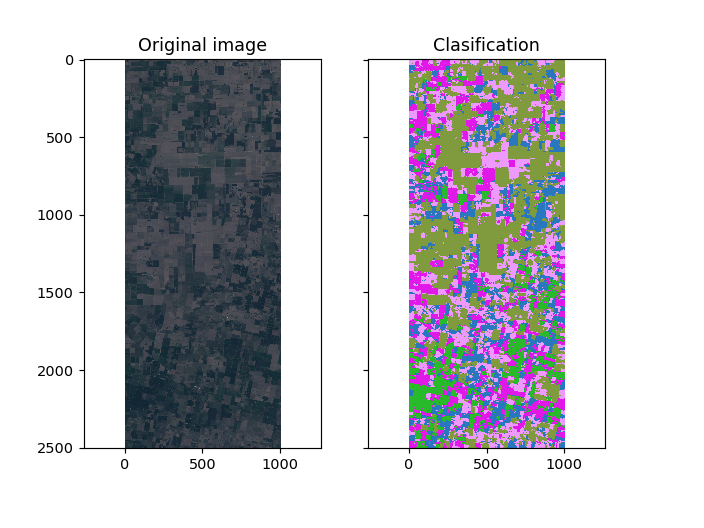

In [37]:
clf = np.copy(segments)
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
img = load("dt.npy")
rgb_img = np.dstack([img[:, :, 3], img[:, :, 2], img[:, :, 1]])
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes_labels), 3)))
ax2.set_title('Clasification')

In [38]:
from pylab import *
verification_pixels=load("test.npy")
print(verification_pixels.shape)

(2500, 1000)
